In [1]:
import numpy as np
import scipy as sp
from scipy import linalg as la
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
file = 'SouthCalifornia-1982-2011_Physics-of-Data.dat'
data = np.genfromtxt(file,
                     dtype=None,
                     delimiter=' ')
data.shape

(110271,)

In [3]:
df = pd.DataFrame(data)
df.columns = ['event', 'prev_event', 'time', 'magnitude', 'x', 'y', 'z']

# 0 - Understanding data

First of all we took a look at the dataset.

In [4]:
df.head()

,event,prev_event,time,magnitude,x,y,z
0,0,-1,0.00000,2.71,-2571956,-4627162,3520602
1,1,0,36501.39072,2.12,-2363740,-4787011,3461373
2,2,0,37488.27744,2.33,-2363746,-4786942,3461232
3,3,0,47982.51648,2.57,-2475085,-4664024,3548479
4,4,0,60268.57056,2.98,-2238642,-4839098,3469546


In [5]:
# we can see that the range of magnitudes is [2,7.3] 
# and that the measurement of time starts from 0 with the first event
df.describe()

,event,prev_event,time,magnitude,x,y,z
count,110271.000000,110271.000000,1.102710e+05,110271.000000,1.102710e+05,1.102710e+05,1.102710e+05
mean,55135.000000,35859.277625,4.262426e+08,2.457920,-2.388225e+06,-4.691072e+06,3.562612e+06
std,31832.640104,36365.001297,2.598605e+08,0.438374,8.878019e+04,1.237294e+05,1.271897e+05
min,0.000000,-1.000000,0.000000e+00,2.000000,-2.770239e+06,-5.020849e+06,3.186133e+06
25%,27567.500000,-1.000000,2.115783e+08,2.140000,-2.421620e+06,-4.801152e+06,3.458838e+06
50%,55135.000000,28462.000000,3.551023e+08,2.340000,-2.361829e+06,-4.699729e+06,3.564367e+06
75%,82702.500000,66972.000000,5.952398e+08,2.640000,-2.329898e+06,-4.615062e+06,3.634552e+06
max,110270.000000,110250.000000,9.305667e+08,7.300000,-1.998294e+06,-4.268289e+06,3.876120e+06


In [6]:
# not all the greatest earthquakes are without ancestors (we shall call them 'prime events')
df[df['magnitude']>6].sort_values(by = 'magnitude', ascending = False)

,event,prev_event,time,magnitude,x,y,z
39805,39805,39804,3.309144e+08,7.30,-2341818,-4710335,3575181
100065,100065,100062,8.915162e+08,7.20,-2294542,-4855348,3390238
75422,75422,75419,5.612489e+08,7.10,-2316706,-4693410,3609984
58367,58367,-1,3.799916e+08,6.70,-2508327,-4610300,3567642
22089,22089,21867,1.859399e+08,6.60,-2322573,-4795291,3462353
89331,89331,-1,6.932159e+08,6.48,-2662869,-4420508,3708948
39859,39859,39858,3.309257e+08,6.30,-2373276,-4692488,3573922
21867,21867,21866,1.858990e+08,6.20,-2316585,-4796535,3470023
37455,37455,37449,3.251864e+08,6.10,-2335795,-4723356,3549940
55532,55532,-1,3.588626e+08,6.10,-2364815,-4481227,3839436


# 1 - Data visualization

## 1.1 - Time distribution

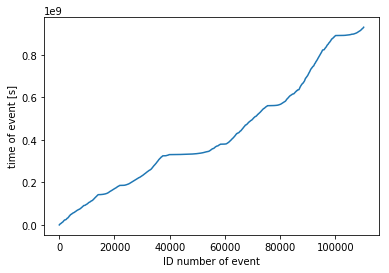

In [7]:
# just a routine look at the time distribution and time scale of the dataset 
%matplotlib inline

plt.plot(df['event'], df['time'])
plt.xlabel('ID number of event')
plt.ylabel('time of event [s]')
plt.show()

## 1.2 - Magnitude distribution

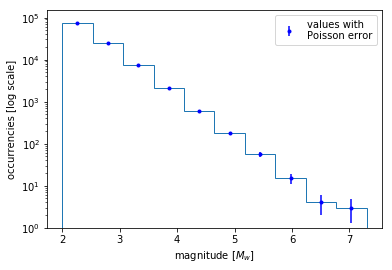

In [8]:
n, bins, _ = plt.hist(df['magnitude'], log = True, histtype = 'step')
bin_centers = (bins[1:] + bins[:-1])/2
plt.errorbar(bin_centers, n, np.sqrt(n), fmt = '.b', label = 'values with \nPoisson error')
plt.xlabel('magnitude [$M_w$]')
plt.ylabel('occurrencies [log scale]')
plt.ylim(bottom = 1)
plt.legend()
plt.show()
plt.close()

## 1.3 - Spatial distribution 

In [9]:
from mpl_toolkits.mplot3d import Axes3D

<IPython.core.display.Javascript object>


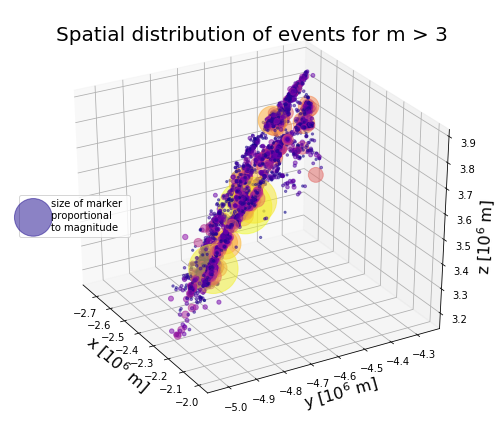

In [11]:
#az = [i*15 for i in range(24)]
#for azim in az:
%matplotlib nbagg
m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
magnitude = dfm['magnitude']

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coord/1e06, y_coord/1e06, z_coord/1e06, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center left')
#print('azim = ', azim)
ax.view_init(elev = 30, azim = 330)
plt.tight_layout()
plt.show()

## PCA for spatial distribution

In [12]:
X = df[['x','y','z']].values.T
X = X.astype("float64")

# centering and rescaling the coordinates
for i in range(3):
    X[i] = (X[i] - X[i].mean())/X[i].std()

In [13]:
# PCA 
C = np.cov(X)
U, spectrum, Vt = la.svd(C)
print ('Spectrum: ', spectrum,'\n')
perc_expl2 = (spectrum[0] + spectrum[1]) / spectrum.sum()
print('Percent of the total variability explained considering the two main features: ', perc_expl2, '\n')

Spectrum:  [2.40189791e+00 5.96194962e-01 1.93433620e-03] 

Percent of the total variability explained considering the two main features:  0.9993552271146224 



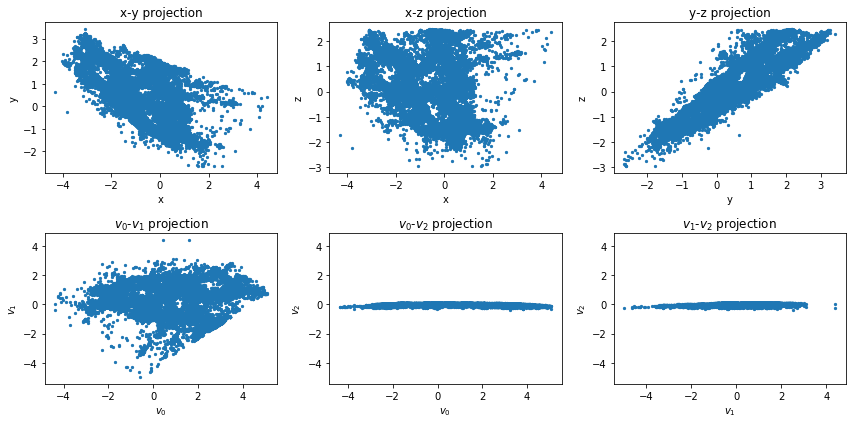

In [14]:
# projecting the data in the plane generated by the two eigenvectors with the largest eigenvalues
Xp = np.dot(Vt,X)

%matplotlib inline
# general plot of the PCA
fig, axes = plt.subplots(nrows=2, ncols=3,
                               figsize=(12, 6))

[[ax01, ax02, ax03],[ax11, ax12, ax13]] = axes

ax01.scatter(X[0], X[1], s= 5)
ax01.set_title('x-y projection')
ax01.set_xlabel('x')
ax01.set_ylabel('y')

ax02.scatter(X[0], X[2], s= 5)
ax02.set_title('x-z projection')
ax02.set_xlabel('x')
ax02.set_ylabel('z')

ax03.scatter(X[1], X[2], s= 5)
ax03.set_title('y-z projection')
ax03.set_xlabel('y')
ax03.set_ylabel('z')

ax11.scatter(Xp[0], Xp[1], s= 5)
ax11.set_title('$v_0$-$v_1$ projection')
(y_bottom, y_top) = ax11.get_ylim()
ax11.set_xlabel('$v_0$')
ax11.set_ylabel('$v_1$')

ax12.scatter(Xp[0], Xp[2], s= 5)
ax12.set_ylim(y_bottom, y_top)
ax12.set_title('$v_0$-$v_2$ projection')
ax12.set_xlabel('$v_0$')
ax12.set_ylabel('$v_2$')

ax13.scatter(Xp[1], Xp[2], s= 5)
ax13.set_ylim(y_bottom, y_top)
ax13.set_title('$v_1$-$v_2$ projection')
ax13.set_xlabel('$v_1$')
ax13.set_ylabel('$v_2$')

plt.tight_layout()
plt.show()

<IPython.core.display.Javascript object>


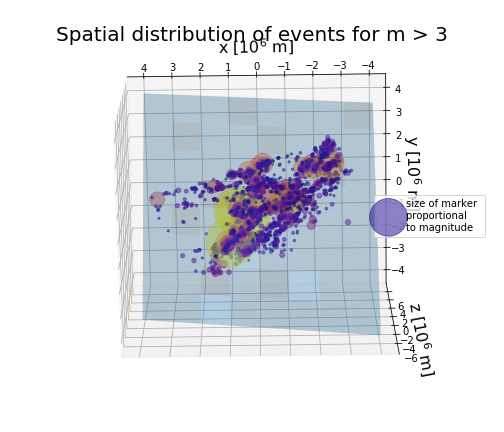

In [55]:
[v1, v2, v3] = Vt
normal = v3
xx, yy = np.meshgrid(range(-4,5), range(-4,5))# calculate corresponding z
z = (-normal[0] * xx - normal[1] * yy ) * 1. /normal[2]

m_bar = 3
dfm = df[df['magnitude'] > m_bar]
x_coord = dfm['x']
y_coord = dfm['y']
z_coord = dfm['z']
x_coord = (x_coord - x_coord.mean())/x_coord.std()
y_coord = (y_coord - y_coord.mean())/y_coord.std()
z_coord = (z_coord - z_coord.mean())/z_coord.std()
magnitude = dfm['magnitude']

%matplotlib nbagg

fig = plt.figure(figsize = (7,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(xx, yy, z, alpha=0.3)
ax.scatter(x_coord, y_coord, z_coord, 
           s=np.exp(magnitude*1.5)/np.exp(3), c = magnitude, marker="o", alpha = 0.5, 
           label = 'size of marker \nproportional \nto magnitude', cmap = 'plasma')
ax.set_xlabel("x [$10^6$ m]", fontsize = 16)
ax.set_ylabel("y [$10^6$ m]", fontsize = 16)
ax.set_zlabel("z [$10^6$ m]", fontsize = 16)
ax.set_title('Spatial distribution of events for m > 3', fontsize = 20)
ax.legend(loc = 'center right')
#print('azim = ', azim)
ax.view_init(elev = 15, azim = 0)
plt.tight_layout()
plt.show()

In [56]:
plt.close()
%matplotlib inline

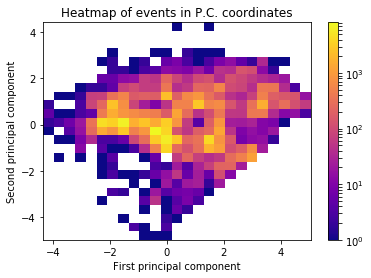

In [62]:
from matplotlib.colors import LogNorm
plt.figure(211)

# farlo in 3D con le barre?
plt.hist2d(Xp[0], Xp[1], bins = 25, norm = LogNorm(), cmap = "plasma")
plt.colorbar()
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Heatmap of events in P.C. coordinates')
plt.show()
plt.close()

# 2 - Distribution of waiting time 
Compute the distribution $P_m(t)$ of waiting times for events of magnitude m or above (i.e. do not consider events below $m$). In shaping the bin sizes, take into account that this distribution is expected to have a power-law decay with time (e.g $\sim 1/t$), and that a power-law is well visualized in log-log scale. Do this analysis for many values of $m$, say $m=2,3,4,5$.

In [63]:
from scipy import optimize
from scipy.stats import chisquare

In [64]:
def select_bin_number(x, min_nbin = 7, fraction = 0.001):
    """Starts from evenly separed bins and merges the last ones until the tail's counts are 
        major or equal to the 'fraction' of the total number of occurrencies, given the 
        constraint that the final number of bins has to be min_nbin."""
    
    n_min = fraction*len(x)
    
    n, bin_extremes, _ = plt.hist(x, bins = min_nbin )
    plt.close()
    last_n = n[-1]
    
    if last_n > n_min:
        return min_nbin, bin_extremes
    else:
        i = min_nbin 
        nbin = min_nbin
        while last_n < n_min and nbin < 100:
            nbin = nbin + 1
            n, _, _ = plt.hist(x, bins = nbin )
            plt.close()
            last_n = n[i-1:].sum()
            
        n, bin_extremes, _ = plt.hist(x, bins = nbin )
        plt.close()
        bins = np.concatenate((bin_extremes[:min_nbin],bin_extremes[-1:]))
        return nbin, bins

In [65]:
def logP(t, A, B):
    return A + B*t

In [66]:
def plot_Pm_t(m, df, sigma_filter = 10):
    print('m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    ax1.plot(time_d)
    #ax1.axhline(time_d.mean()*2 + sigma_filter*time_d.std(), c = 'r')
    prova = time_d[time_d != time_d.max()]
    maximum = prova.max()
    if time_d.max()*3/4 > maximum:
        time_d = prova
    #time_d = time_d[mask]
    #print('Eliminated samples : ', len(timem) - len(time_d) -1, '\n')
    ax2.plot(time_d)
    
    plt.show()
    plt.close()
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    
    # computing suitable sizes of bins
    bin_number, bins = select_bin_number(time_diff)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    
    n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
    ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    
    print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

    # rescaling the tail entries with the number of bins merged into the tail
    n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(logP, bin_centers, np.log(n), p0 = [np.log(n[0]),-1])
    [A,B] = params1
    print('A = {}\nB = {}'.format(round(A,2), round(B,2)))
    
    # chi squared and p-value tests
    chisq, p = chisquare(np.log(n), logP(bin_centers, *params1), ddof = 2 )
    
    ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
    ax2.plot(bin_centers, logP(bin_centers, *params1), 
             label = 'A = {} \nB = {}\n$\chi^2$ = {} \np-value = {}'\
             .format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(p,2)))
    ax2.legend()

    plt.show()
    plt.close()
    
    gridsize = (2, 3)
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax1.plot(time_diff)
    
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
    n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
    #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
    ax2.set_xscale('log')
    ax2.axis('off')
    plt.show()
    plt.close()
    
    # parameters of Pm from the one of logPm 
    a = np.exp(A)
    b = -B/time_d.max()
    return a, b, chisq, p

m =  2.0 



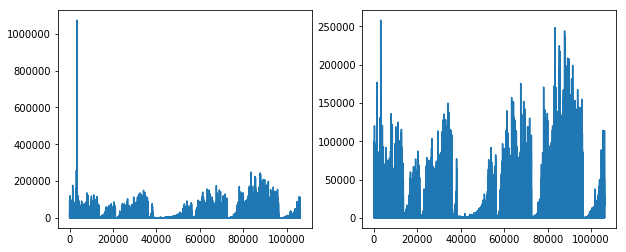

Occurrencies for the first bin with 12 original bins:  93444.0 

A = 10.63
B = -11.36


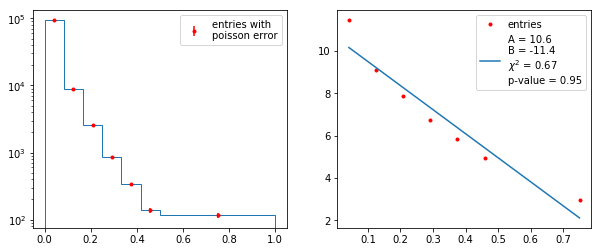

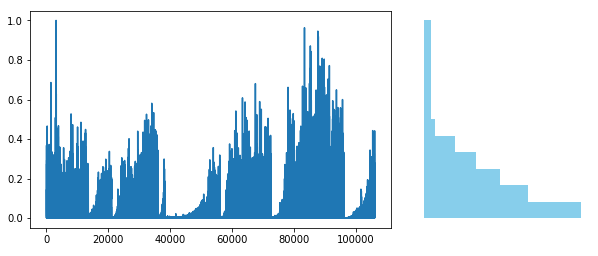

m =  2.5 



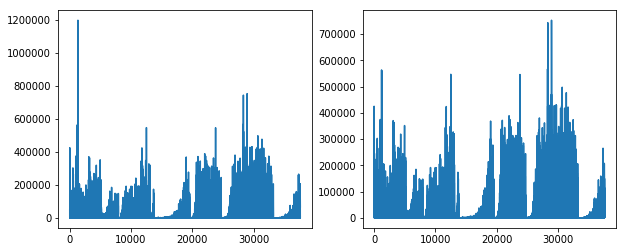

Occurrencies for the first bin with 13 original bins:  32640.0 

A = 9.52
B = -11.35


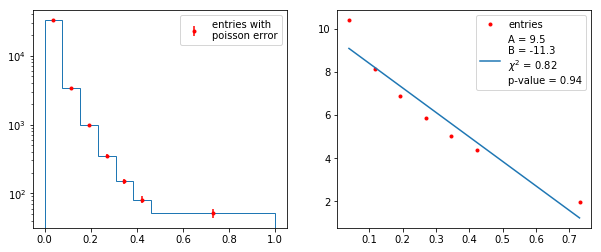

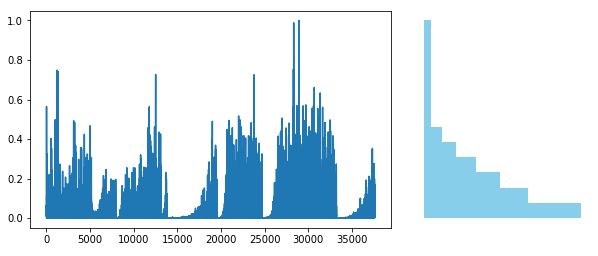

m =  3.0 



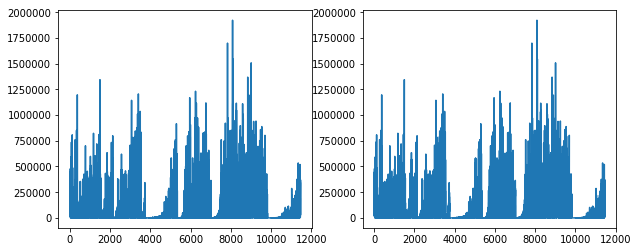

Occurrencies for the first bin with 10 original bins:  9908.0 

A = 8.76
B = -10.25


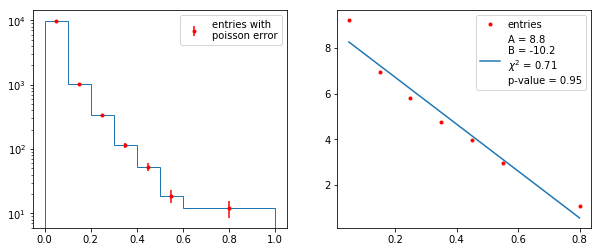

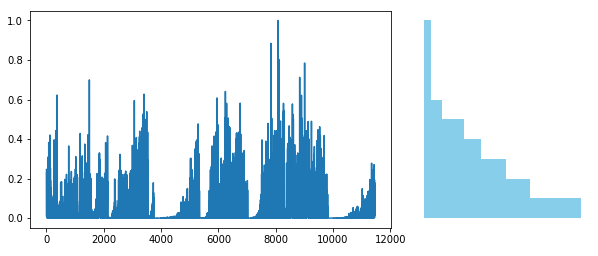

m =  3.5 



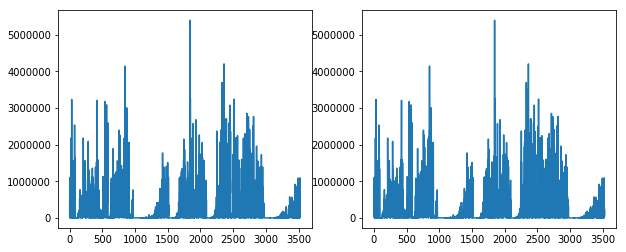

Occurrencies for the first bin with 9 original bins:  3029.0 

A = 7.67
B = -9.2


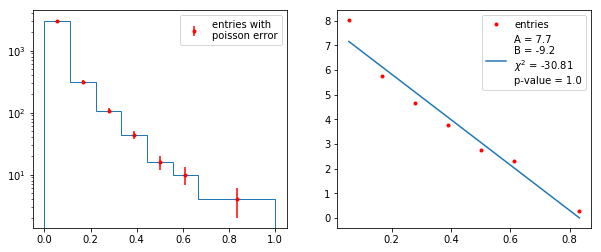

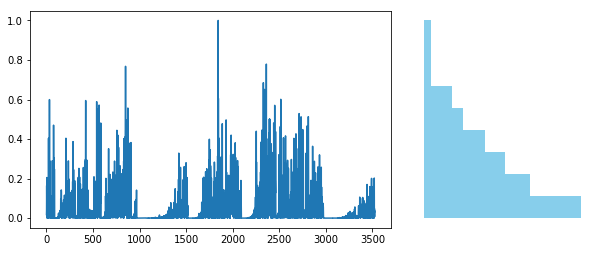

m =  4.0 



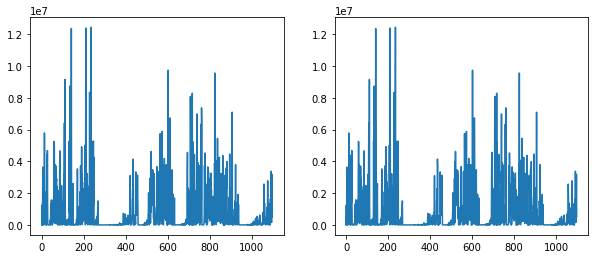

Occurrencies for the first bin with 7 original bins:  921.0 

A = 6.42
B = -6.64


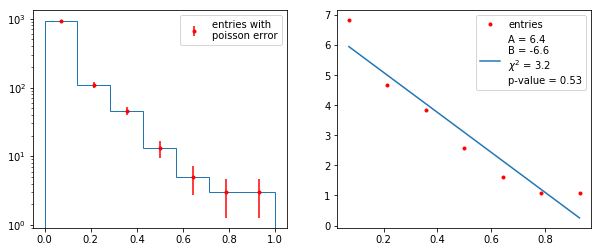

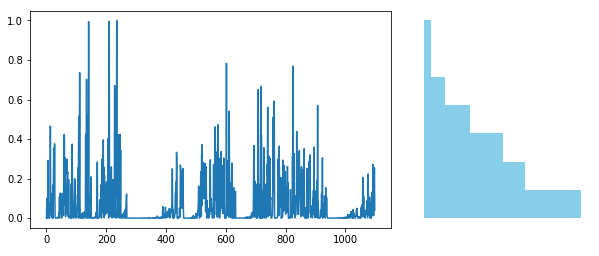

m =  4.5 



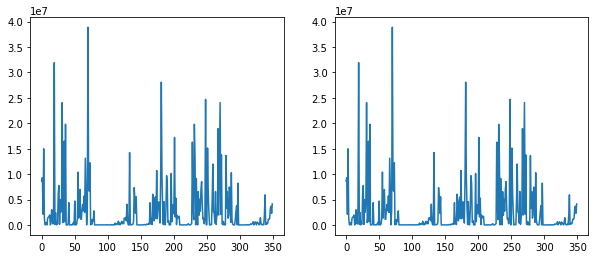

Occurrencies for the first bin with 7 original bins:  298.0 

A = 5.1
B = -5.97


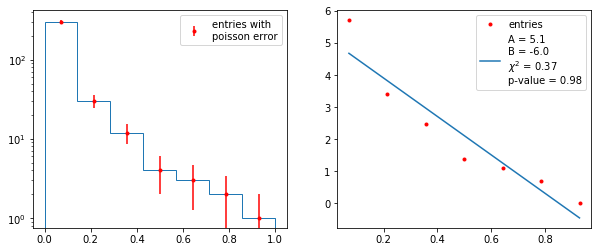

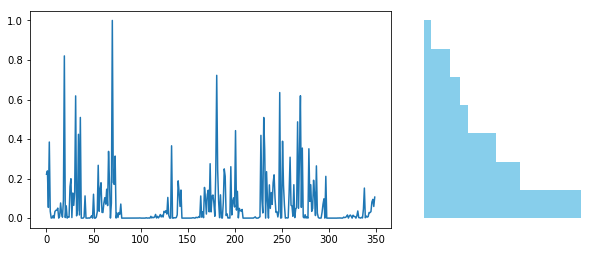

m =  5.0 



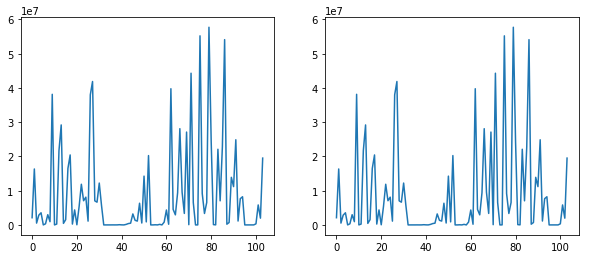

Occurrencies for the first bin with 7 original bins:  75.0 

A = 3.55
B = -3.43


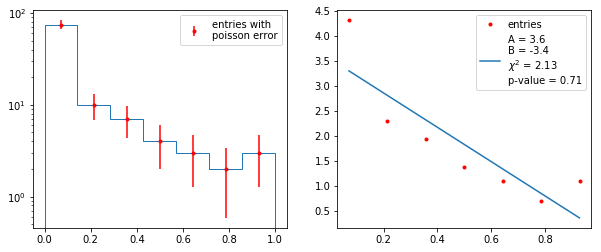

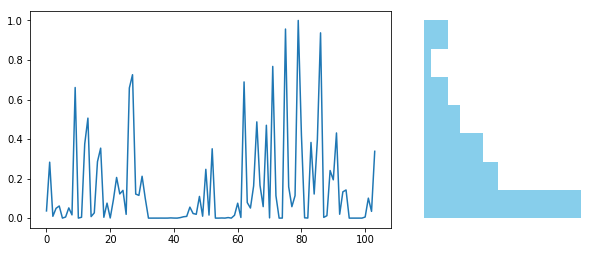

In [67]:
ms = np.linspace(2,5,7)

As = np.zeros(len(ms))
Bs = np.zeros(len(ms))
chis = np.zeros(len(ms))
ps = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    As[i], Bs[i], chis[i], ps[i] = plot_Pm_t(m, df)

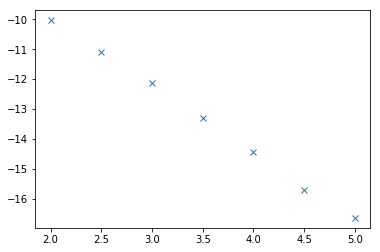

In [68]:
plt.plot(ms, np.log(Bs), 'x')
plt.show()

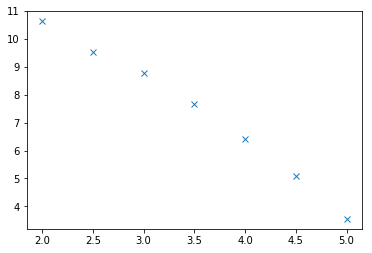

In [69]:
#questo lascia il tempo che trova
plt.plot(ms, np.log(As), 'x')
plt.show()

# 3 - Distribution of distance between events

Compute the distribution $P_m(r)$ of the distance between an event and the next one, considering earthquakes of magnitude m or above. Also here make a clever choice for the bin sizes and try several values of $m$.

In [70]:
m = 3
dfm = df[df['magnitude'] > m]
X = np.array(dfm[['x','y','z']])
r = np.linalg.norm(X[1:]-X[:-1], axis = 1)


In [71]:
def plot_Pm_r(m, df, sigma_filter = 10):
    print('m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_norm = r/r.max()
    
    
    # computing suitable sizes of bins
    bin_number, bins = select_bin_number(r_norm)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    
    n, bin_extremes, _  = ax1.hist(r_norm, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
    ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    
    print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

    # rescaling the tail entries with the number of bins merged into the tail
    n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(logP, bin_centers, np.log(n), p0 = [np.log(n[0]),-1])
    [A,B] = params1
    print('A = {}\nB = {}'.format(round(A,2), round(B,2)))
    
    # chi squared and p-value tests
    chisq, p = chisquare(np.log(n), logP(bin_centers, *params1), ddof = 2 )
    
    ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
    ax2.plot(bin_centers, logP(bin_centers, *params1), 
             label = 'A = {} \nB = {}\n$\chi^2$ = {} \np-value = {}'\
             .format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(p,2)))
    ax2.legend()

    plt.show()
    plt.close()
    
    gridsize = (2, 3)
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax1.plot(r)
    
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
    n2, bins2, patches2 = ax2.hist(r, bins = bins, orientation = 'horizontal', color = 'skyblue')
    #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
    ax2.set_xscale('log')
    ax2.axis('off')
    plt.show()
    plt.close()
    
    # parameters of Pm from the one of logPm 
    a = np.exp(A)
    b = -B/r.max()
    return a, b, chisq, p, r.mean(), r.std()/len(r)

m =  2.0 

Occurrencies for the first bin with 8 original bins:  56422.0 

A = 11.4
B = -5.98


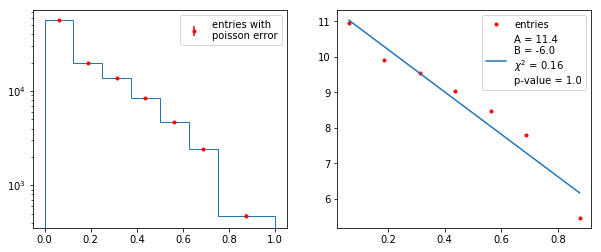

/home/nicola/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:3152: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=1.0, right=1.0
  'left=%s, right=%s') % (left, right))


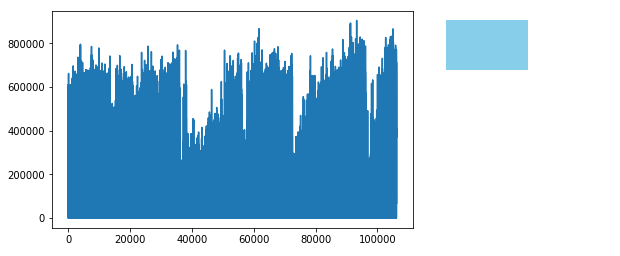

m =  2.230769230769231 

Occurrencies for the first bin with 7 original bins:  37992.0 

A = 11.19
B = -6.16


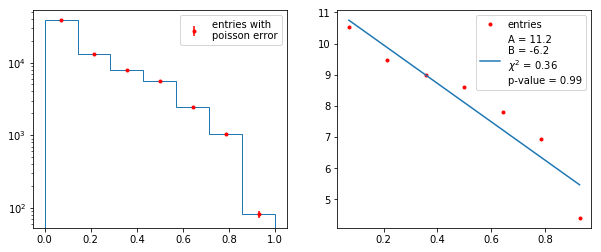

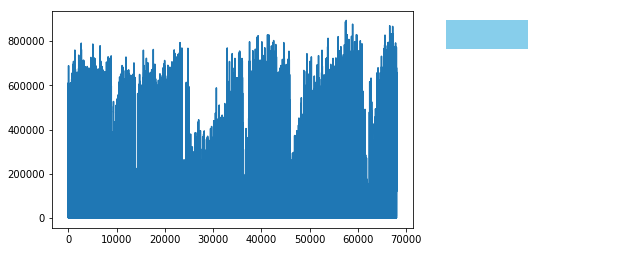

m =  2.4615384615384617 

Occurrencies for the first bin with 7 original bins:  23607.0 

A = 10.55
B = -5.68


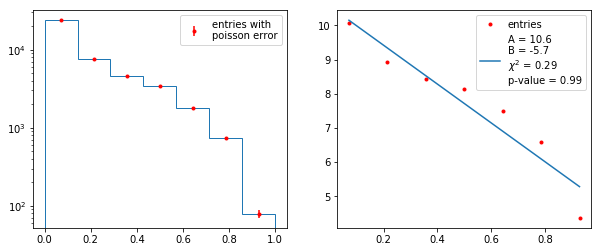

/home/nicola/anaconda3/lib/python3.7/site-packages/matplotlib/ticker.py:2207: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


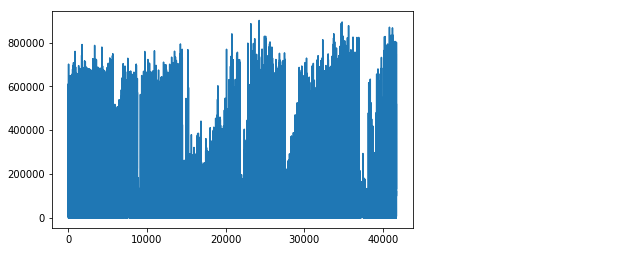

m =  2.6923076923076925 

Occurrencies for the first bin with 8 original bins:  13899.0 

A = 9.98
B = -6.24


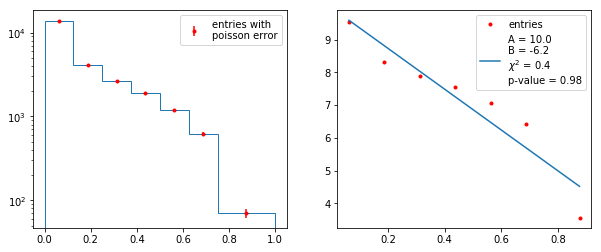

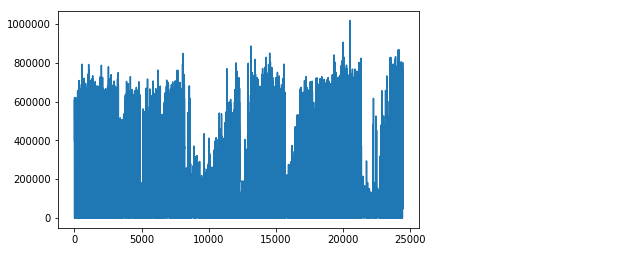

m =  2.9230769230769234 

Occurrencies for the first bin with 8 original bins:  8240.0 

A = 9.28
B = -5.77


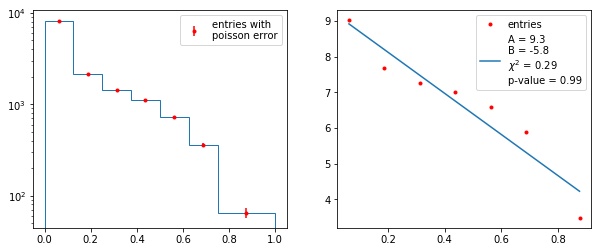

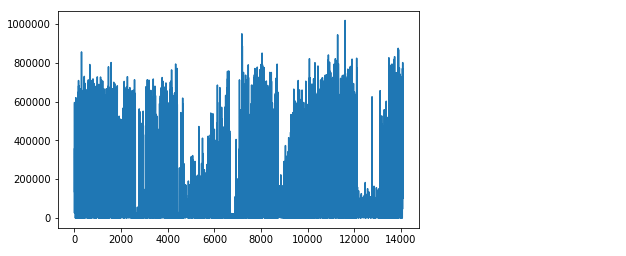

m =  3.153846153846154 

Occurrencies for the first bin with 8 original bins:  4764.0 

A = 8.67
B = -5.65


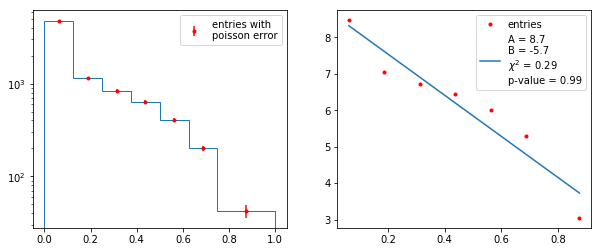

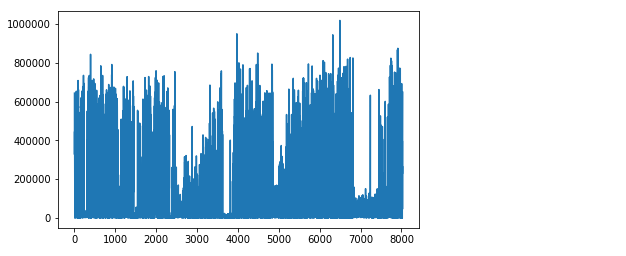

m =  3.3846153846153846 

Occurrencies for the first bin with 7 original bins:  2922.0 

A = 8.44
B = -6.09


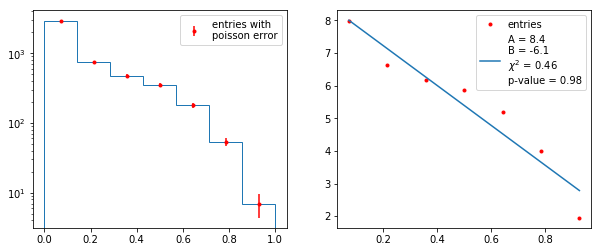

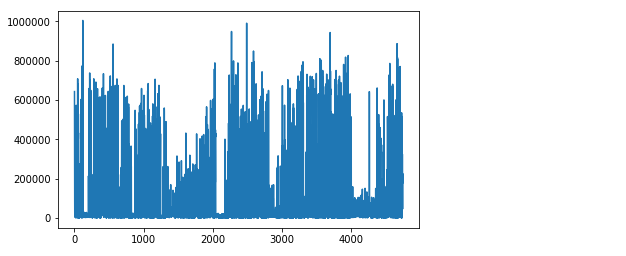

m =  3.6153846153846154 

Occurrencies for the first bin with 7 original bins:  1686.0 

A = 7.85
B = -6.0


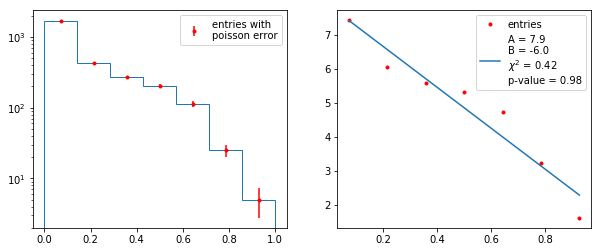

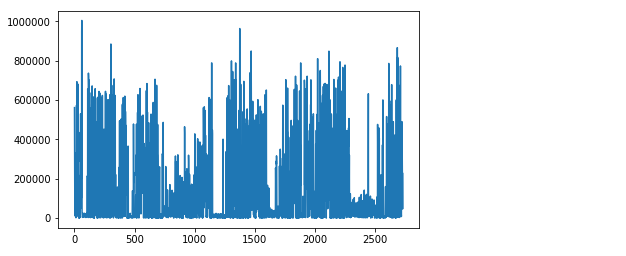

m =  3.8461538461538463 

Occurrencies for the first bin with 7 original bins:  973.0 

A = 7.28
B = -5.89


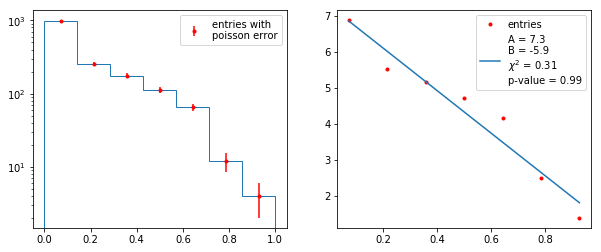

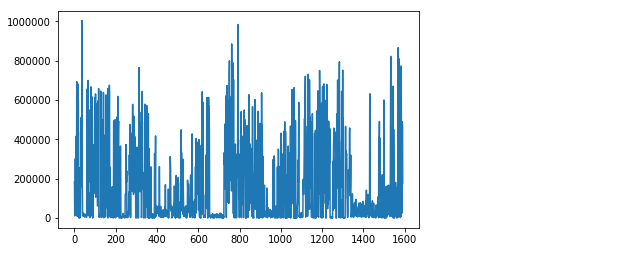

m =  4.076923076923077 

Occurrencies for the first bin with 7 original bins:  558.0 

A = 6.3
B = -4.32


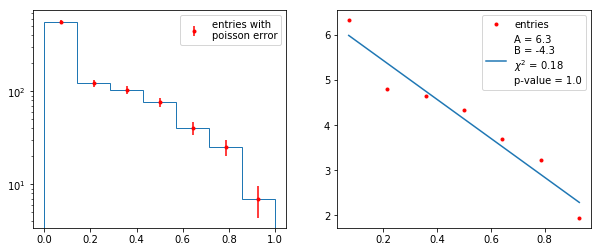

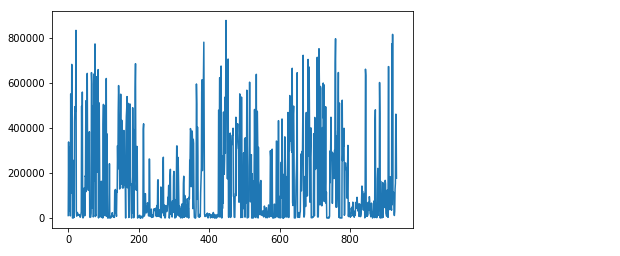

m =  4.307692307692308 

Occurrencies for the first bin with 7 original bins:  322.0 

A = 5.74
B = -4.14


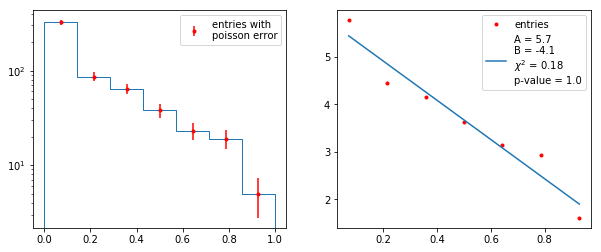

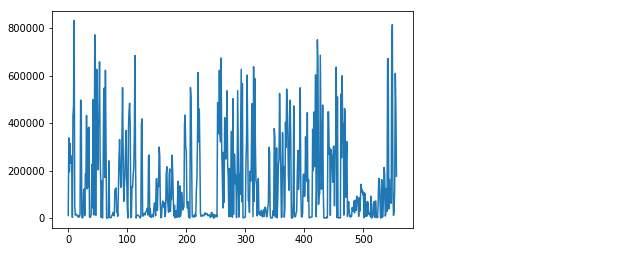

m =  4.538461538461538 

Occurrencies for the first bin with 7 original bins:  203.0 

A = 5.17
B = -4.34


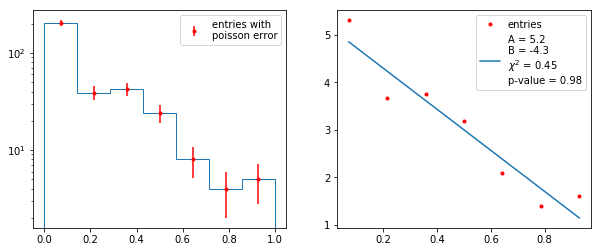

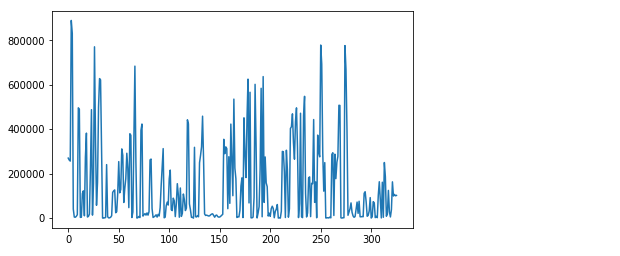

m =  4.769230769230769 

Occurrencies for the first bin with 7 original bins:  120.0 

A = 4.35
B = -3.38


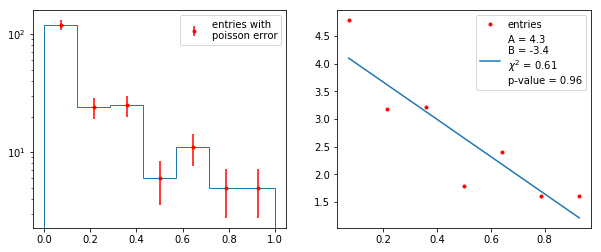

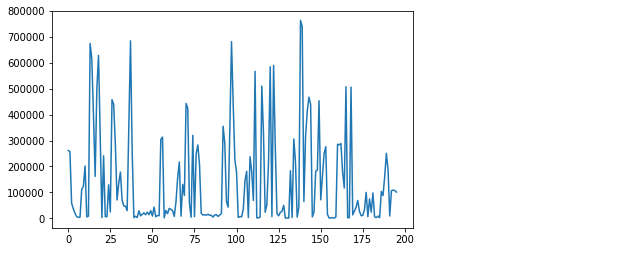

m =  5.0 

Occurrencies for the first bin with 7 original bins:  55.0 

A = 3.81
B = -3.22


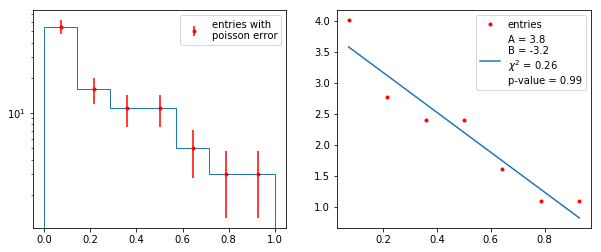

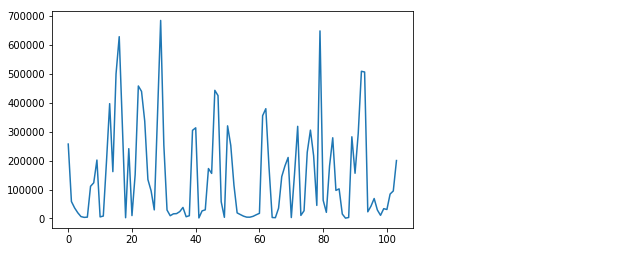

In [72]:
ms = np.linspace(2,5,14)

Ar = np.zeros(len(ms))
Br = np.zeros(len(ms))
chir = np.zeros(len(ms))
pr = np.zeros(len(ms))
r_mean = np.zeros(len(ms))
r_std = np.zeros(len(ms))
for i in range(len(ms)):
    m = ms[i]
    Ar[i], Br[i], chir[i], pr[i], r_mean[i], r_std[i] = plot_Pm_r(m, df)

In [ ]:
plt.plot(ms, Br*1e06, 'x')
plt.show()

In [ ]:
plt.errorbar(ms, r_mean, yerr = r_std, fmt = 'b.')
plt.show()

In [ ]:
r_indep_events = []
for i in range(len(ms)):
    dfm = df[(df['magnitude'] > ms[i]) & (df['prev_event'] == -1)]
    X = np.array(dfm[['x','y','z']])
    r = np.linalg.norm(X[1:]-X[:-1], axis = 1)
    r_indep_events.append(r.mean())


In [ ]:
plt.errorbar(ms, r_mean, yerr = r_std, fmt = 'b.', label = 'all events')
plt.plot(ms, r_indep_events, 'r.', label = 'indep. events')
plt.legend(loc = 'center')
#plt.legend(loc = 10)
plt.show()

# Branches / families

In [ ]:
def evees_light(df, index=-1, depth=0):
    dataset = {}
    df_filtered = df[df["prev_event"]==index]
    lenght =  df_filtered.shape[0]
    for i in range(lenght):
        event = df_filtered.iloc[i]
        #dataset[str(event["id"])] = {"event" : event}
        dataset[str(int(event["event"]))] = {"depth" : depth}
        dataset[str(int(event["event"]))]["children"] = evees_light(df, index=int(event["event"]), depth = depth + 1)
    return dataset

In [ ]:
tree_dataset = evees_light(df)

In [ ]:
from copy import deepcopy

In [ ]:
new_df = deepcopy(df)
new_df['edges'] = 0
new_df['depth'] = 0

In [ ]:
def write_dict_array(dataset, dict_array):
    for k in dataset.keys():
        depth = dataset[k]['depth']
        # k is the keyword, children_ids are the values
        if len(dict_array) < depth + 1 :
            while len(dict_array) < depth + 1:
                dict_array.append({})
        else:
            dict_array[depth][k] = list(dataset[k]['children'].keys())
        if len(list(dataset[k]['children'].keys())) != 0:
            write_dict_array(dataset[k]['children'], dict_array)

In [ ]:
v_dict = [{}]

In [ ]:
write_dict_array(tree_dataset, v_dict)

In [ ]:
N = df.shape[0]
edges = np.zeros(N)
depths = np.zeros(N)

In [ ]:
for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        #print(k)
        edges[int(k)] = len(v_dict[d][k])
        depths[int(k)] = d

In [ ]:
df['edges'] = edges
df['depth'] = depths

In [ ]:
df[df['magnitude'] == 7.3]

In [ ]:
mean_mag = df.groupby('depth')['magnitude'].mean()
print(len(mean_mag))

In [ ]:
print(len(v_dict[0]['0']))

In [ ]:
depth_axis = [i for i in range(len(mean_mag))]
plt.plot(depth_axis, mean_mag)
plt.show()

In [ ]:
time_diff_tree = np.zeros(N)

for d in range(len(v_dict)):
    for k in v_dict[d].keys():
        # previous vertex has id = k, children vertexes have ids [ v_dict[d][k] ]
        for j in v_dict[d][k]:
            #print('Computing {}-> {} waiting time.'.format(k,j))
            time_diff_tree[int(j)] = df['time'].iloc[int(j)] - df['time'].iloc[int(k)]

In [ ]:
time_diff_tree = time_diff_tree[time_diff_tree > 0]

In [ ]:
def logPmod(t, A, B, C):
    return A + B/t**C

def logt(t, p, q, r):
    return p*np.log(t*r) + q

In [ ]:
def plot_Pm_t_tree(time_d, sigma_filter = 10):

    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    
    # computing suitable sizes of bins
    bin_number, bins = select_bin_number(time_diff)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    
    n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
    ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    
    print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

    # rescaling the tail entries with the number of bins merged into the tail
    n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
    # linear fit over the log of the entries
    #params1, _ = optimize.curve_fit(logPmod, bin_centers, np.log(n), p0 = [np.log(n[0]),-1,1])
    params1, _ = optimize.curve_fit(logt, bin_centers, np.log(n), p0 = [-1,5,1])
    [A,B,C] = params1
    print('A = {}\nB = {}\nC = {}'.format(round(A,2), round(B,2), round(C,2)))
    
    # chi squared and p-value tests
    chisq, p = chisquare(np.log(n), logt(bin_centers, *params1), ddof = 2 )
    
    ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
    ax2.plot(bin_centers, logt(bin_centers, *params1), 
             label = 'A = {} \nB = {}\nC = {}\n$\chi^2$ = {} \np-value = {}'\
             .format(round(params1[0],1),round(params1[1],1),round(params1[2],1),round(chisq,2),round(p,2)))
    ax2.legend()

    plt.show()
    plt.close()
    
    gridsize = (2, 3)
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax1.plot(time_diff)
    
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
    n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
    #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
    ax2.set_xscale('log')
    ax2.axis('off')
    plt.show()
    plt.close()
    
    # parameters of Pm from the one of logPm 
    a = np.exp(A)
    b = -B/time_d.max()**C
    return a, b, C, chisq, p

In [ ]:
a, b, C, chisq, p = plot_Pm_t_tree(time_diff_tree )

In [ ]:
a, b, C, chisq, p = plot_Pm_t_tree(time_diff_tree )

In [ ]:
a, b, C, chisq, p = plot_Pm_t_tree(time_diff_tree )

In [ ]:
def plot_Pm_t1(m, df, sigma_filter = 10):
    print('m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    ax1.plot(time_d)
    #ax1.axhline(time_d.mean()*2 + sigma_filter*time_d.std(), c = 'r')
    prova = time_d[time_d != time_d.max()]
    maximum = prova.max()
    if time_d.max()*3/4 > maximum:
        time_d = prova
    #time_d = time_d[mask]
    #print('Eliminated samples : ', len(timem) - len(time_d) -1, '\n')
    ax2.plot(time_d)
    
    plt.show()
    plt.close()
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    
    # computing suitable sizes of bins
    bin_number, bins = select_bin_number(time_diff)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    
    n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
    ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    
    print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

    # rescaling the tail entries with the number of bins merged into the tail
    n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(logt, bin_centers, np.log(n), p0 = [-1,5,1])
    [p,q,r] = params1
    print('p = {}\nq = {}\nr = {}'.format(round(p,2), round(q,2), round(r,2)))
    
    # chi squared and p-value tests
    chisq, pv = chisquare(np.log(n), logt(bin_centers, *params1), ddof = 2 )
    
    ax2.plot(bin_centers, np.log(n), 'r.', label = 'entries')
    ax2.plot(bin_centers, logt(bin_centers, *params1), 
             label = 'p = {} \nq = {}\nr = {}\n$\chi^2$ = {} \np-value = {}'\
             .format(round(params1[0],1),round(params1[1],1),round(params1[2],1),round(chisq,2),round(pv,2)))
    ax2.legend()

    plt.show()
    plt.close()
    
    gridsize = (2, 3)
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax1.plot(time_diff)
    
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
    n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
    #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
    ax2.set_xscale('log')
    ax2.axis('off')
    plt.show()
    plt.close()
    
    # parameters of Pm from the one of logPm 
    #a = np.exp(A)
    #b = -B/time_d.max()
    return p, q, r, chisq, pv

In [ ]:
ms = np.linspace(2,5,7)

ps = np.zeros(len(ms))
qs = np.zeros(len(ms))
rs = np.zeros(len(ms))
chis = np.zeros(len(ms))
pvs = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    ps[i], qs[i], rs[i], chis[i], pvs[i] = plot_Pm_t1(m, df)

In [ ]:
plt.plot(ms, ps )
plt.show()

In [74]:
def loglogt(t, p, q):
    return p*t + q

In [73]:
def plot_Pm_t2(m, df, sigma_filter = 10):
    print('m = ', m, '\n')
    # waiting time for events of magnitude > m
    dfm = df[df['magnitude'] > m]
    timem = np.array(dfm['time'])
    timem.sort()
    time_d = timem[1:] - timem[:-1]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    ax1.plot(time_d)
    #ax1.axhline(time_d.mean()*2 + sigma_filter*time_d.std(), c = 'r')
    prova = time_d[time_d != time_d.max()]
    maximum = prova.max()
    if time_d.max()*3/4 > maximum:
        time_d = prova
    #time_d = time_d[mask]
    #print('Eliminated samples : ', len(timem) - len(time_d) -1, '\n')
    ax2.plot(time_d)
    
    plt.show()
    plt.close()
    # time differences rescaled to [0,1]
    time_diff = time_d/time_d.max()
    
    
    # computing suitable sizes of bins
    bin_number, bins = select_bin_number(time_diff)
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
    
    n, bin_extremes, _  = ax1.hist(time_diff, bins = bins, histtype = 'step')
    
    bin_centers = (bin_extremes[:-1] + bin_extremes[1:])/2
    sigma_n = np.sqrt(n)
    ax1.errorbar(bin_centers, n, sigma_n, fmt = 'r.', label = 'entries with \npoisson error')
    ax1.legend(loc = 'upper right')
    ax1.set_yscale('log')
    
    print('Occurrencies for the first bin with {} original bins: '.format(bin_number), n[0], '\n')

    # rescaling the tail entries with the number of bins merged into the tail
    n = np.concatenate((n[:-1], n[-1:]/(bin_number+1-7)))
    # linear fit over the log of the entries
    params1, _ = optimize.curve_fit(loglogt, np.log(bin_centers), np.log(n), p0 = [-1,5])
    [p,q] = params1
    print('p = {}\nq = {}'.format(round(p,2), round(q,2)))
    
    # chi squared and p-value tests
    chisq, pv = chisquare(np.log(n), loglogt(np.log(bin_centers), *params1), ddof = 2 )
    
    ax2.plot(np.log(bin_centers), np.log(n), 'r.', label = 'entries')
    ax2.plot(np.log(bin_centers), loglogt(np.log(bin_centers), *params1), 
             label = 'p = {} \nq = {}\n$\chi^2$ = {} \np-value = {}'\
             .format(round(params1[0],1),round(params1[1],1),round(chisq,2),round(pv,2)))
    ax2.legend()

    plt.show()
    plt.close()
    
    gridsize = (2, 3)
    fig = plt.figure(figsize=(10, 4))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
    ax1.plot(time_diff)
    
    ax2 = plt.subplot2grid(gridsize, (0, 2), colspan = 1, rowspan = 2)
    n2, bins2, patches2 = ax2.hist(time_diff, bins = bins, orientation = 'horizontal', color = 'skyblue')
    #hist_with_kde(ax2, time_diff, bins = bins, histtype = 'step', orientation = 'horizontal')
    ax2.set_xscale('log')
    ax2.axis('off')
    plt.show()
    plt.close()
    
    # parameters of Pm from the one of logPm 
    #a = np.exp(A)
    #b = -B/time_d.max()
    return p, q, chisq, pv

m =  2.0 



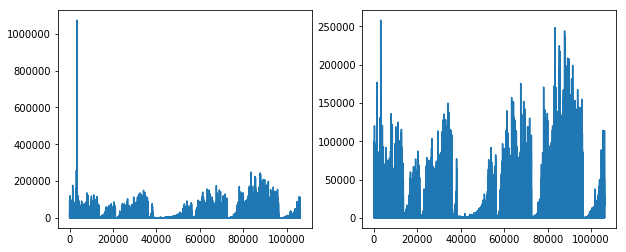

Occurrencies for the first bin with 12 original bins:  93444.0 

p = -2.89
q = 2.81


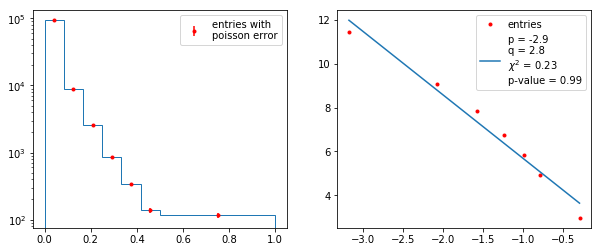

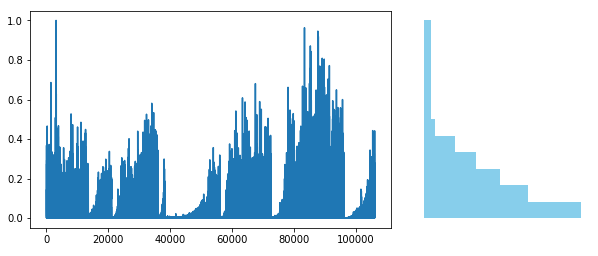

m =  2.230769230769231 



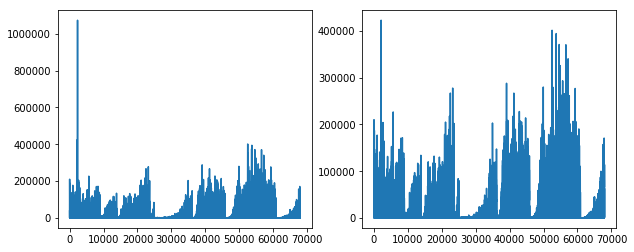

Occurrencies for the first bin with 13 original bins:  59295.0 

p = -2.81
q = 2.36


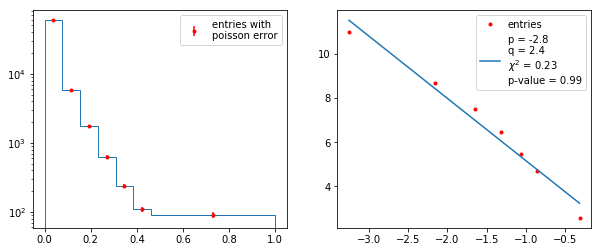

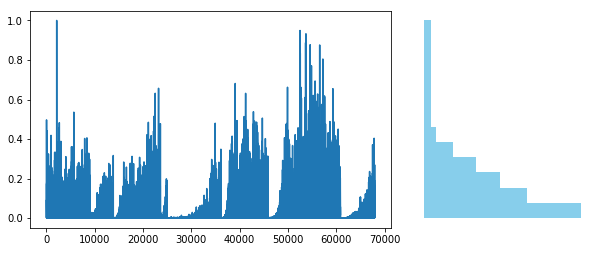

m =  2.4615384615384617 



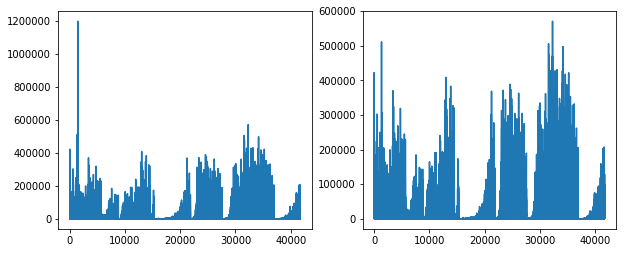

Occurrencies for the first bin with 10 original bins:  36797.0 

p = -2.86
q = 2.44


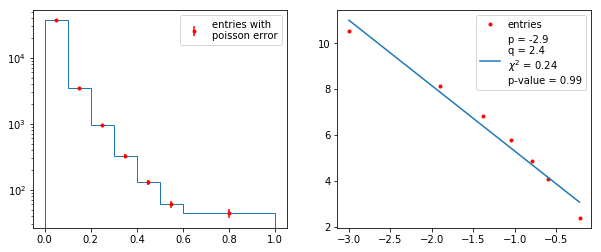

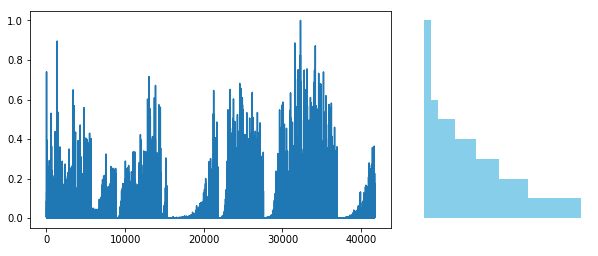

m =  2.6923076923076925 



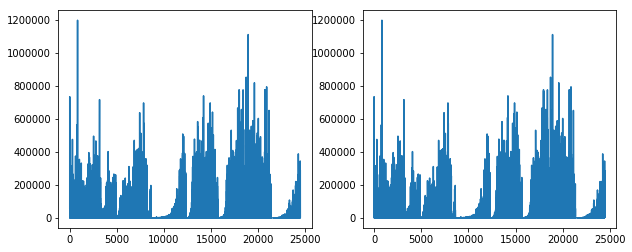

Occurrencies for the first bin with 12 original bins:  21609.0 

p = -2.92
q = 1.25


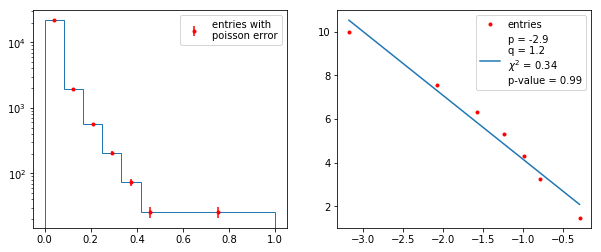

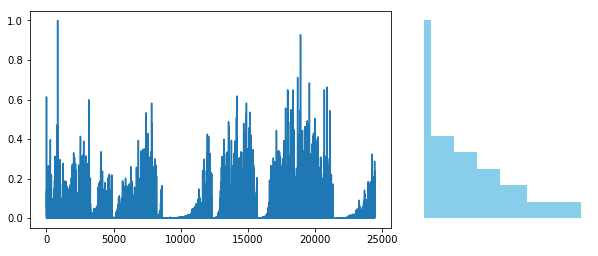

m =  2.9230769230769234 



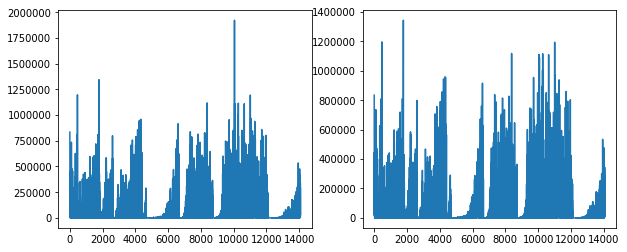

Occurrencies for the first bin with 9 original bins:  12115.0 

p = -2.68
q = 2.14


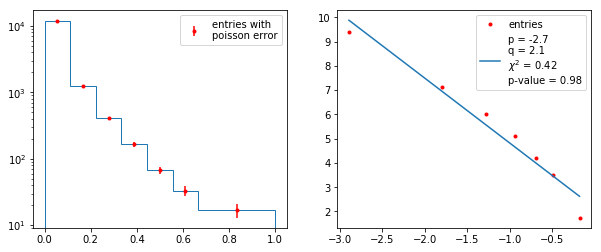

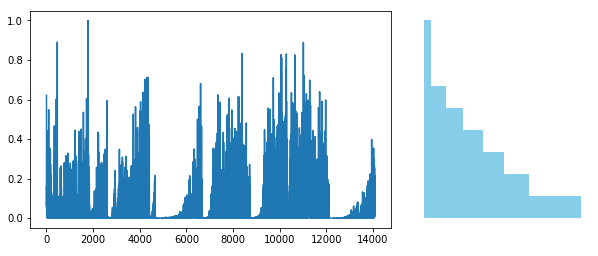

m =  3.153846153846154 



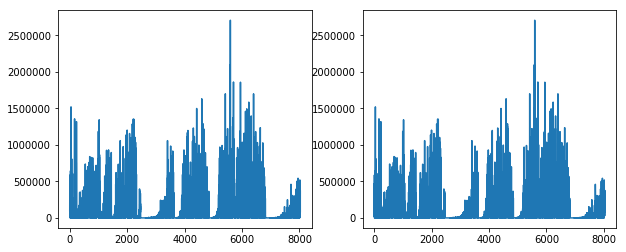

Occurrencies for the first bin with 11 original bins:  6784.0 

p = -2.7
q = 1.08


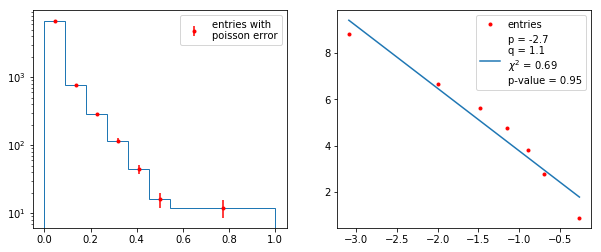

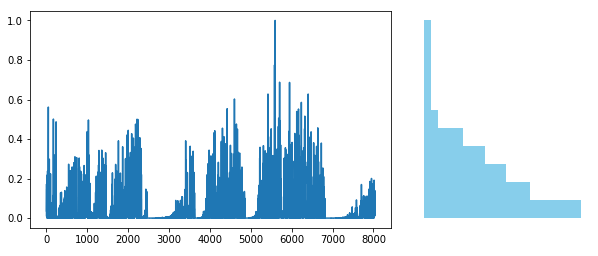

m =  3.3846153846153846 



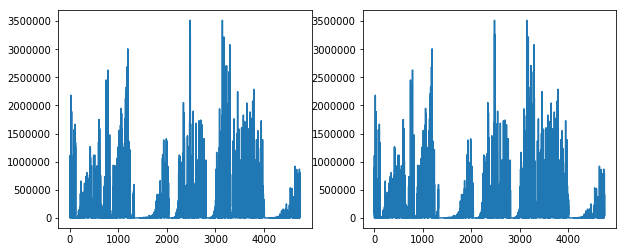

Occurrencies for the first bin with 7 original bins:  4144.0 

p = -2.69
q = 1.59


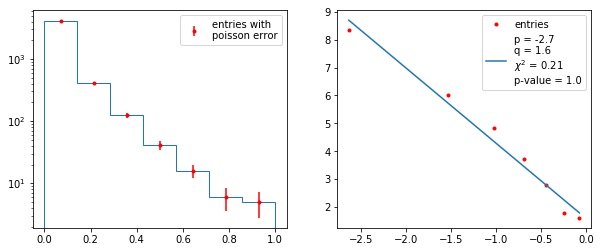

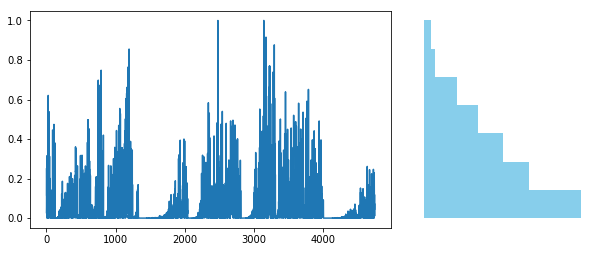

m =  3.6153846153846154 



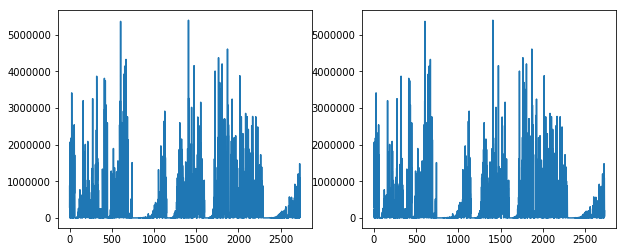

Occurrencies for the first bin with 8 original bins:  2274.0 

p = -2.31
q = 1.6


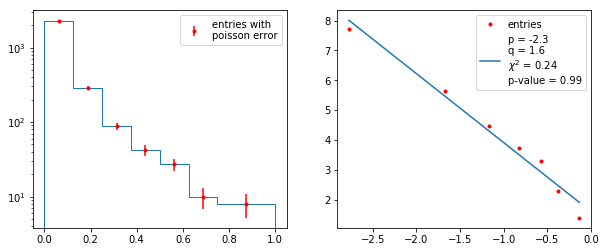

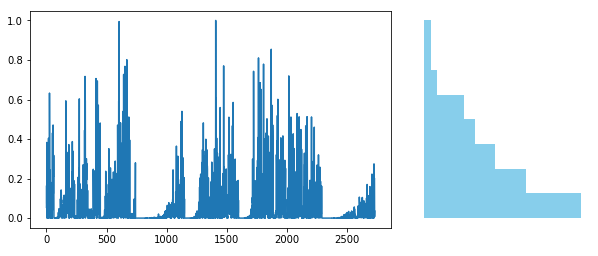

m =  3.8461538461538463 



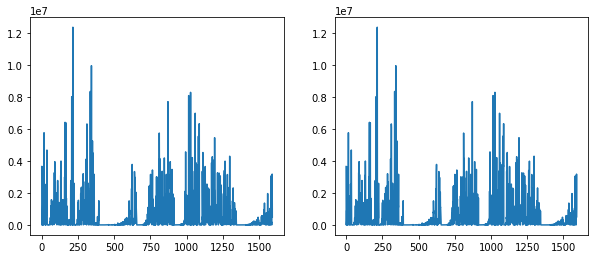

Occurrencies for the first bin with 8 original bins:  1409.0 

p = -2.65
q = 0.19


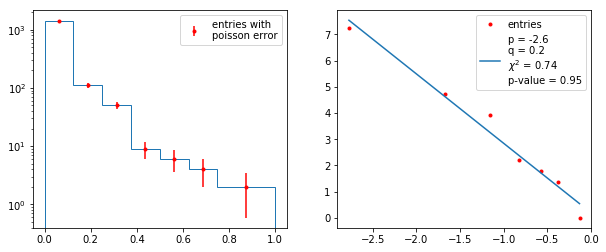

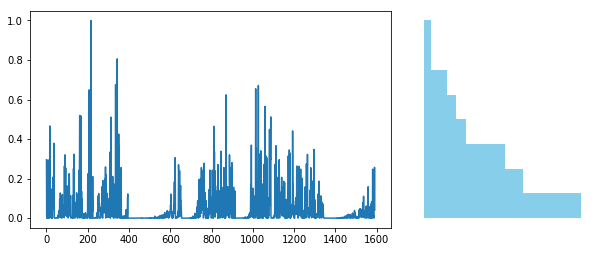

m =  4.076923076923077 



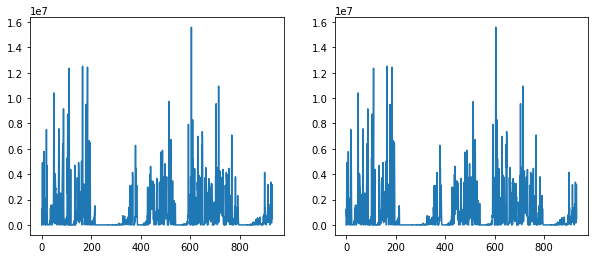

Occurrencies for the first bin with 7 original bins:  784.0 

p = -2.49
q = 0.46


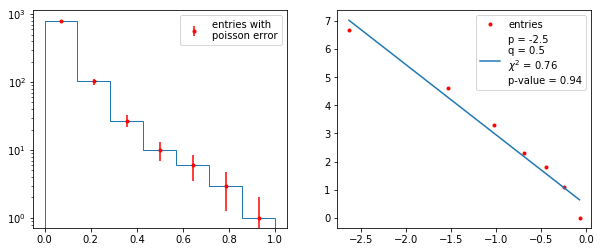

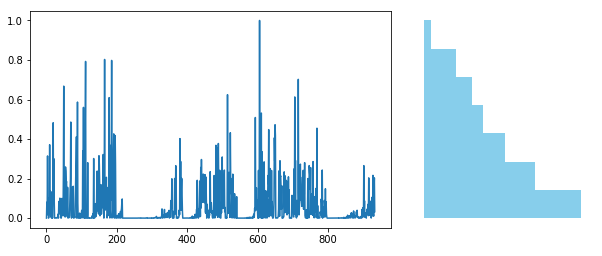

m =  4.307692307692308 



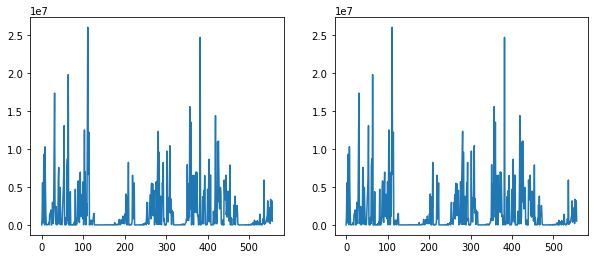

Occurrencies for the first bin with 7 original bins:  471.0 

p = -2.4
q = 0.05


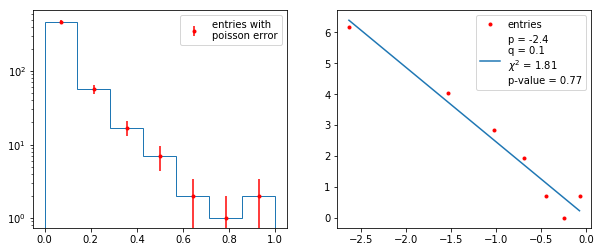

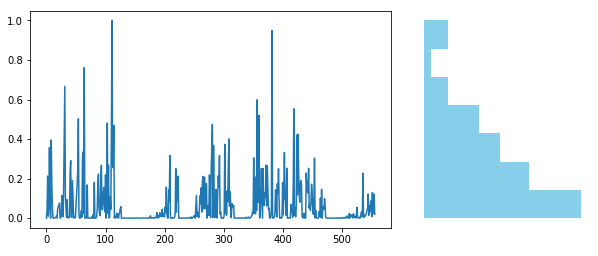

m =  4.538461538461538 



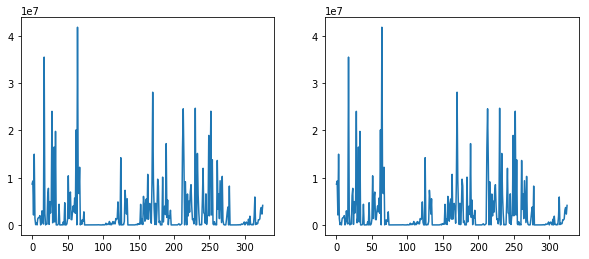

Occurrencies for the first bin with 7 original bins:  278.0 

p = -2.19
q = -0.07


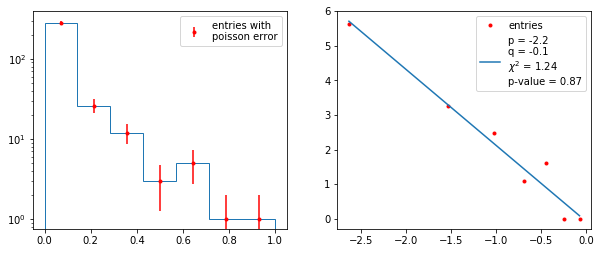

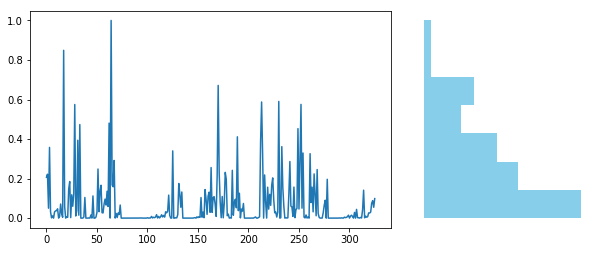

m =  4.769230769230769 



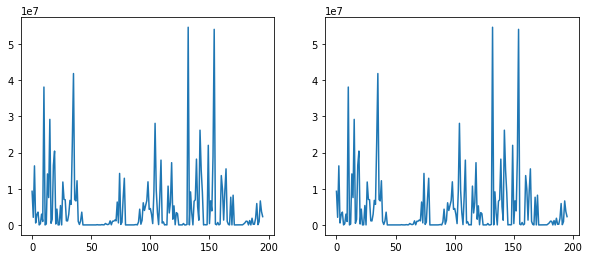

Occurrencies for the first bin with 7 original bins:  162.0 

p = -1.99
q = -0.19


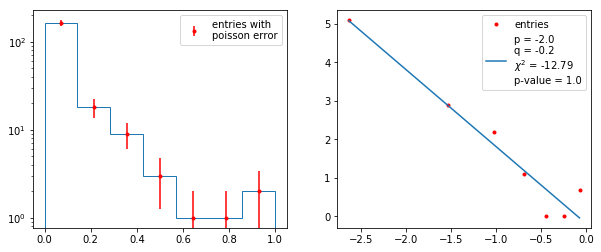

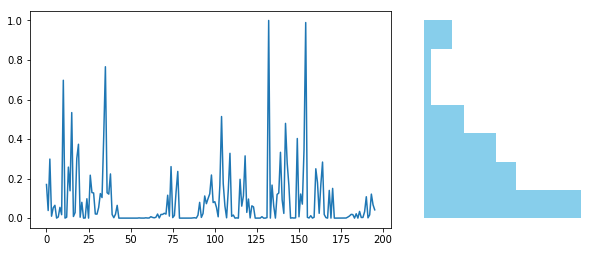

m =  5.0 



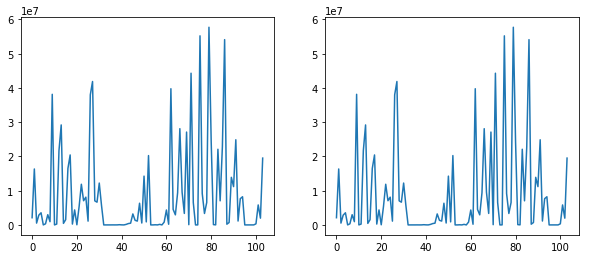

Occurrencies for the first bin with 7 original bins:  75.0 

p = -1.34
q = 0.56


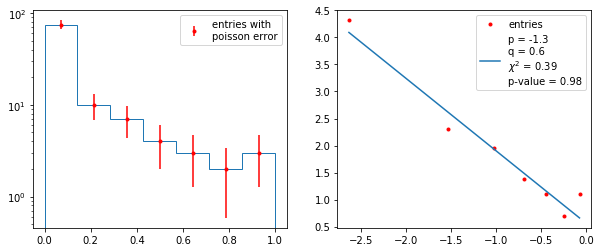

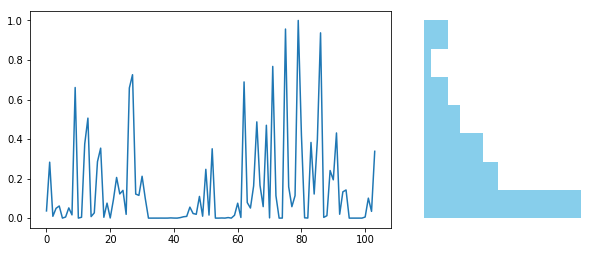

In [75]:
ps1 = np.zeros(len(ms))
qs1 = np.zeros(len(ms))
chis1 = np.zeros(len(ms))
pvs1 = np.zeros(len(ms))

for i in range(len(ms)):
    m = ms[i]
    ps1[i], qs1[i], chis1[i], pvs1[i] = plot_Pm_t2(m, df)

In [ ]:
def exponent(m, a):
    return 1 + ( a - 1)*np.exp(-2+m)

def parabolic(x,a,b,c):
    return a*x**2 + b*x + c

In [ ]:
param_a, _ = optimize.curve_fit(exponent, ms, ps, p0 = [3])
a = param_a[0]
print('a = {}'.format(round(a,2)))

In [ ]:
parab_p, _ = optimize.curve_fit(parabolic, ms, ps)
[a,b,c] = parab_p
a = round(a,2)
b = round(b,2)
c = round(c,2)

In [ ]:
plt.plot(ms, ps, 'x', label = 'coeff with logt' )
plt.plot(ms, ps1, label = 'coeff with loglogt' )
#plt.plot(ms, exponent(ms, *param_a), label = 'fit')
plt.plot(ms, parabolic(ms, *parab_p), 
         label = 'fit $ax^2+bx+c$ \na = {}, b = {}, c = {}'.format(a,b,c))
plt.title('$p_m$ of $t_{w}^{-p_m}$', fontsize = 15 )
plt.xlabel('magnitude m')
plt.ylabel('coeff. p')
plt.legend()
plt.show()